In [38]:
local = True

In [39]:
if not local:
    ! pip install sdv
    ! pip install gretel-synthetics

In [40]:
import sys

import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import collections as coll
import tqdm

#from synthetic_data_generation.generator import *
# Import libraries
from sdv.sequential.par import PARSynthesizer
from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata

import matplotlib.dates as md
import torch
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType
import dtw

if local:
    sys.path.append('../../src/')
    from similarity_check.SimilarityCheck import *
    from privacy_check.privacy_check import PrivacyCheck


In [41]:
def get_energy_data_metadata(rows_limit = 1000, interpolate = True, drop_na_cols = True):
    datasets = load_csvs(folder_name='./data/') if local else load_csvs(folder_name='.')
    df = datasets["energy_dataset"].iloc[:rows_limit]
    if drop_na_cols:
        df = df.dropna(axis = 1, how = "all")
    if interpolate:
        df = df.interpolate()
    
    # Switch the shape of the dataframe to long format
    gen_columns = list(filter(lambda x: "generation" in x, df.columns))
    df_long = df.melt(["time"], gen_columns)
    df_long.columns = ["time","energy_source", "value"]

    # Clean time and energy_source column
    df_long["time"] = pd.to_datetime(df_long["time"], utc = True).dt.tz_localize(None)
    df_long["energy_source"] = df_long["energy_source"].apply(lambda x: x.replace("generation ", ""))

    # Metadata
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df_long)

    metadata.update_column(
        "energy_source",
        sdtype='id',
    )
    metadata.set_sequence_key("energy_source")
    metadata.update_column(
        column_name='time',
        sdtype='datetime',
        datetime_format='%Y-%m-%d %H:%M:%S')
    metadata.set_sequence_index(column_name='time')


    return df_long, metadata

def plot_original_synthetic_ts(df_original, df_synth, count_real = 5, count_synth = 1):
    # Plot original data vs. synthetic data
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    by_source = df_original.groupby('energy_source')
    MAX_COUNT = [count_real, count_synth]
    c = 0

    for i, df in enumerate([df_original, df_synth]):
        by_source = df.groupby('energy_source')
        c = 0
        for name, group in by_source:
            if i == 1:
                name = None
            if c == MAX_COUNT[i]:
                break
            c += 1
            axs[i].plot(group['time'], group['value'], label=name)
        if i == 0:
            axs[i].legend()
        axs[i].set_xlabel("Date")
        axs[i].set_ylabel("Energy generation")

    axs[0].set_title("Original data")
    axs[1].set_title("Synthetic data")
    plt.show()

def compute_dtw_matrix(df_original, df_synth, metadata):
    """
    Function that computes the DTW for every combination of original & synthetic sequences.

    :param df_original: original dataframe in long format
    :param df_synth: synthetic dataframe generated with PAR
    :param metadata: metadata of original dataframe

    -----------

    Returns: DataFrame with distance matrix
    """
    meta_dict = metadata.to_dict()
    sequence_key, sequence_index = meta_dict["sequence_key"], meta_dict["sequence_index"]
    ts_col = list(filter(lambda x: x not in [sequence_key, sequence_index], df_synth.columns))[0]
    sequence_key_values_synth = df_synth[sequence_key].unique()
    sequence_key_values_original = df_original[sequence_key].unique()

    dist_matrix = pd.DataFrame(np.zeros((len(sequence_key_values_synth), len(sequence_key_values_original))), columns=sequence_key_values_original,
                               index=sequence_key_values_synth)


    for i, row in enumerate(dist_matrix.iterrows()):
        synth_key, row = row
        ts_synth = df_synth[df_synth[sequence_key] == synth_key][ts_col].dropna().values
        if len(ts_synth) == 0:
            dist_matrix.iloc[i, :] = np.full(len(sequence_key_values_original),np.nan)
            continue
        for j, original_key in enumerate(sequence_key_values_original):
            ts_original = df_original[df_original[sequence_key] == original_key][ts_col].dropna().values
            if len(ts_original) == 0:
                dist_matrix.iloc[i, j] = np.nan
                continue
            alignment = dtw.dtw(ts_synth, ts_original)
            dist = alignment.normalizedDistance
            dist_matrix.iloc[i, j] = dist


    return dist_matrix

# Possible methods
For the generation of synthetic datasets with time series data, we have several methods at our disposal:
- PARSynthesizer (```sdv```): Probabilistic AutoRegressive model that allows learning multi-type, multivariate timeseries data and later on generate new synthetic data that has the same format and properties as the learned one.
- DoppelGANger (```gretel-synthetics```): DoppelGANger is based on a generative adversarial network (GAN) with some modifications to better fit the time series generation task.
- TimeGAN (```ydata-synthetic```): GAN based adapted to time series using a new concept: supervised loss.

## PARSynthesizer

### Full dataset

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 5, cuda = True)

# Step 2: Train the synthesizer
synthesizer.fit(df)

# Step 3: Generate synthetic data.
synthetic_data = synthesizer.sample(num_sequences=5)

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
Epoch 5 | Loss 9.208951814798638e-05: 100%|██████████| 5/5 [13:13<00:00, 158.65s/it]
100%|██████████| 5/5 [00:00<00:00, 42.91it/s]


In [ ]:
synthetic_data = synthesizer.sample(num_sequences=1000)

100%|██████████| 1000/1000 [00:07<00:00, 132.71it/s]


In [ ]:
synthetic_data

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,id
0,NaN,NaN,NaN,5
1,NaN,NaN,5886.168980,6
2,329.164791,149.625888,5532.381462,7
3,NaN,385.316568,4701.346904,8
4,NaN,273.639084,NaN,9
...,...,...,...,...
995,NaN,0.000000,5308.164467,1000
996,NaN,NaN,6454.271889,1001
997,403.984260,999.000000,NaN,1002
998,425.551263,NaN,3069.256701,1003


In [ ]:
synthetic_data = synthetic_data.drop("id", axis = 1)

In [ ]:
na_rows = synthetic_data.isna().apply(lambda x: np.prod(x), axis = 1).sum()
synthetic_data.isna()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas
0,True,True,True
1,True,True,False
2,False,False,False
3,True,False,False
4,True,False,True
...,...,...,...
995,True,False,False
996,True,True,False
997,False,False,True
998,False,True,False


In [ ]:
print(f"We have {na_rows} rows that contain only NA values")

We have 146 rows that contain only NA values


In [ ]:
# Setup for our dataset
df = datasets["energy_dataset"]
df = df[["time", "generation biomass", "generation fossil brown coal/lignite", "generation fossil gas"]]
df["time"] = df["time"].apply(lambda x: x[:-6])
df["time"] = pd.to_datetime(df["time"])

In [ ]:
df

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas
0,2015-01-01 00:00:00,447.0,329.0,4844.0
1,2015-01-01 01:00:00,449.0,328.0,5196.0
2,2015-01-01 02:00:00,448.0,323.0,4857.0
3,2015-01-01 03:00:00,438.0,254.0,4314.0
4,2015-01-01 04:00:00,428.0,187.0,4130.0
...,...,...,...,...
35059,2018-12-31 19:00:00,297.0,0.0,7634.0
35060,2018-12-31 20:00:00,296.0,0.0,7241.0
35061,2018-12-31 21:00:00,292.0,0.0,7025.0
35062,2018-12-31 22:00:00,293.0,0.0,6562.0


### Smaller dataset

#### With NA values

In [13]:
df_long, metadata = get_energy_data_metadata(interpolate=False, drop_na_cols=False)

/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/datasets/local.py:31: UserWarning: Ignoring incompatible files ['.DS_Store'] in folder './data/'.
  warnings.warn(
2023-05-17 15:56:46,083 : MainThread : INFO : Detected metadata:
2023-05-17 15:56:46,083 : MainThread : INFO : {
    "columns": {
        "time": {
            "sdtype": "datetime"
        },
        "energy_source": {
            "sdtype": "categorical"
        },
        "value": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}


In [6]:
df_long

,time,energy_source,value
0,2014-12-31 23:00:00+00:00,biomass,447.0
1,2015-01-01 00:00:00+00:00,biomass,449.0
2,2015-01-01 01:00:00+00:00,biomass,448.0
3,2015-01-01 02:00:00+00:00,biomass,438.0
4,2015-01-01 03:00:00+00:00,biomass,428.0
...,...,...,...
20995,2015-02-11 10:00:00+00:00,wind onshore,9396.0
20996,2015-02-11 11:00:00+00:00,wind onshore,8364.0
20997,2015-02-11 12:00:00+00:00,wind onshore,7684.0
20998,2015-02-11 13:00:00+00:00,wind onshore,6762.0


In [7]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 50, cuda = True)

# Step 2: Train the synthesizer
synthesizer.fit(df_long)

2023-05-17 15:41:44,925 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:41:44,927 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:41:44,928 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:41:44,928 : MainThread : INFO : Setting the configuration for the ``HyperTransformer`` for table None
2023-05-17 15:41:45,012 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:41:45,013 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:41:45,014 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:41:45,014 : MainThread : INFO : Fitting HyperTransformer for table None
2023-05-17 15:41:45,022 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:41:45,022 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:41:45,023 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:41:45,023 : MainThread : INFO : Setting the configuration for the ``HyperTransf

In [14]:
# Analyzing NA values
epochs_list = [5, 10, 50, 100, 200]
na_values = []
for epochs in epochs_list:
    # Step 1: Create the synthesizer
    synthesizer = PARSynthesizer(metadata, verbose = True, epochs = epochs, cuda = True)
    # Step 2: Train the synthesizer
    synthesizer.fit(df_long)
    # Step 3: Generate synthetic data.
    synthetic_data = synthesizer.sample(num_sequences=1)
    na_count = synthetic_data.isna().sum()["value"]
    na_values.append(na_count)

2023-05-17 15:56:51,213 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:56:51,215 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:56:51,216 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:56:51,217 : MainThread : INFO : Setting the configuration for the ``HyperTransformer`` for table None
2023-05-17 15:56:51,304 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:56:51,305 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:56:51,306 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:56:51,306 : MainThread : INFO : Fitting HyperTransformer for table None
2023-05-17 15:56:51,314 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:56:51,315 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:56:51,315 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:56:51,315 : MainThread : INFO : Setting the configuration for the ``HyperTransf

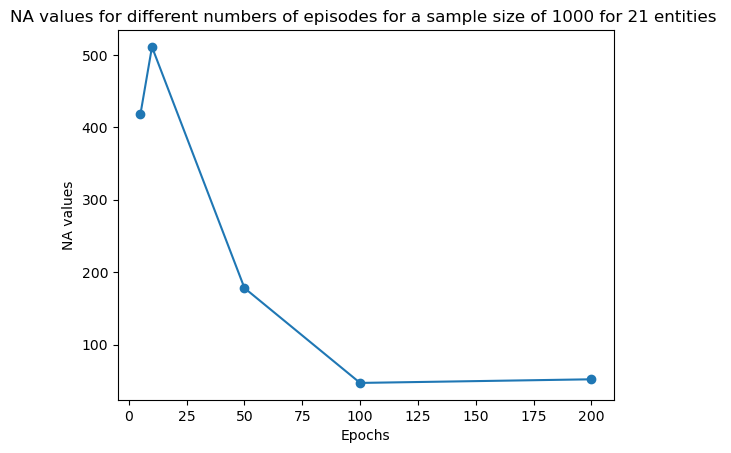

In [15]:
# Plot NA values
plt.plot(epochs_list, na_values, marker = "o")
plt.title("NA values for different numbers of episodes for a sample size of 1000 for 21 entities ")
plt.xlabel("Epochs")
plt.ylabel("NA values")
plt.show()

In [16]:
synthetic_data_plot = synthesizer.sample(5)

100%|██████████| 5/5 [00:22<00:00,  4.51s/it]
/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/data_processing/data_processor.py:751: FutureWarning: Using .astype to convert from timezone-naive dtype to timezone-aware dtype is deprecated and will raise in a future version.  Use ser.dt.tz_localize instead.
  reversed_data[column_name] = column_data[column_data.notna()].astype(dtype)


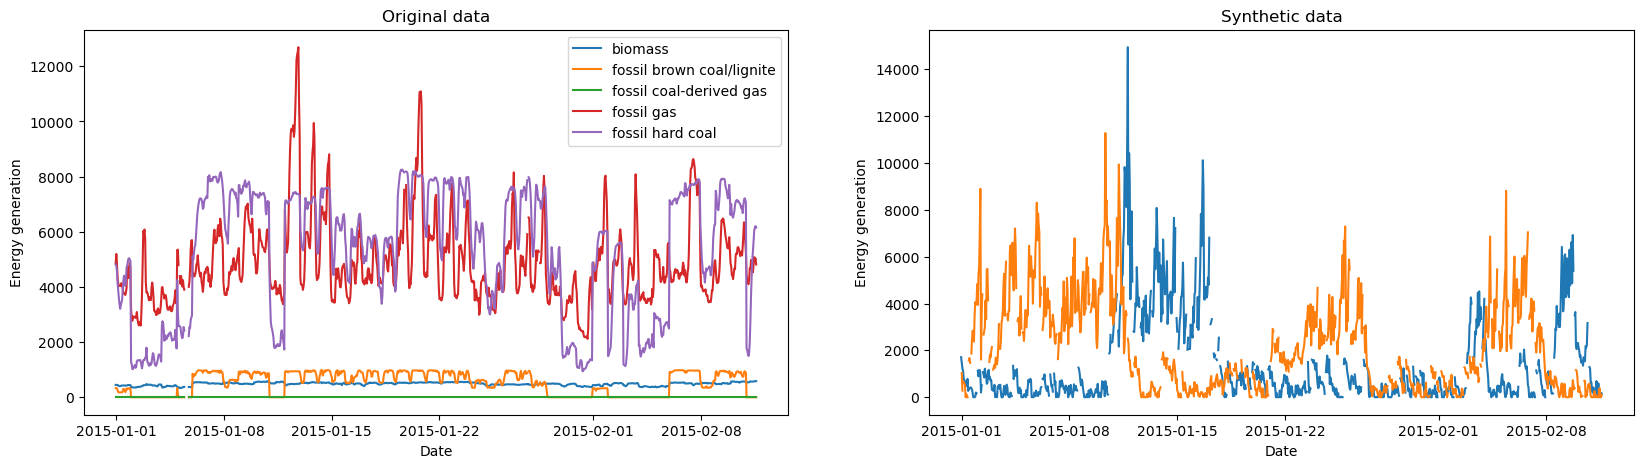

In [19]:
plot_original_synthetic_ts(df_long, synthetic_data_plot, 5, 2)

#### Interpolating NA values

In [23]:
df_long, metadata = get_energy_data_metadata(rows_limit=1000, interpolate= True, drop_na_cols=True)

/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/datasets/local.py:31: UserWarning: Ignoring incompatible files ['.DS_Store'] in folder './data/'.
  warnings.warn(
2023-05-23 15:56:04,387 : MainThread : INFO : Detected metadata:
2023-05-23 15:56:04,387 : MainThread : INFO : {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "time": {
            "sdtype": "datetime"
        },
        "energy_source": {
            "sdtype": "categorical"
        },
        "value": {
            "sdtype": "numerical"
        }
    }
}


In [24]:
# Load model
synthesizer = PARSynthesizer.load("./models/energy1000_300ep_linint.pkl")

synth_data = synthesizer.sample(5)

100%|██████████| 5/5 [00:31<00:00,  6.32s/it]
/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/data_processing/data_processor.py:751: FutureWarning: Using .astype to convert from timezone-naive dtype to timezone-aware dtype is deprecated and will raise in a future version.  Use ser.dt.tz_localize instead.
  reversed_data[column_name] = column_data[column_data.notna()].astype(dtype)


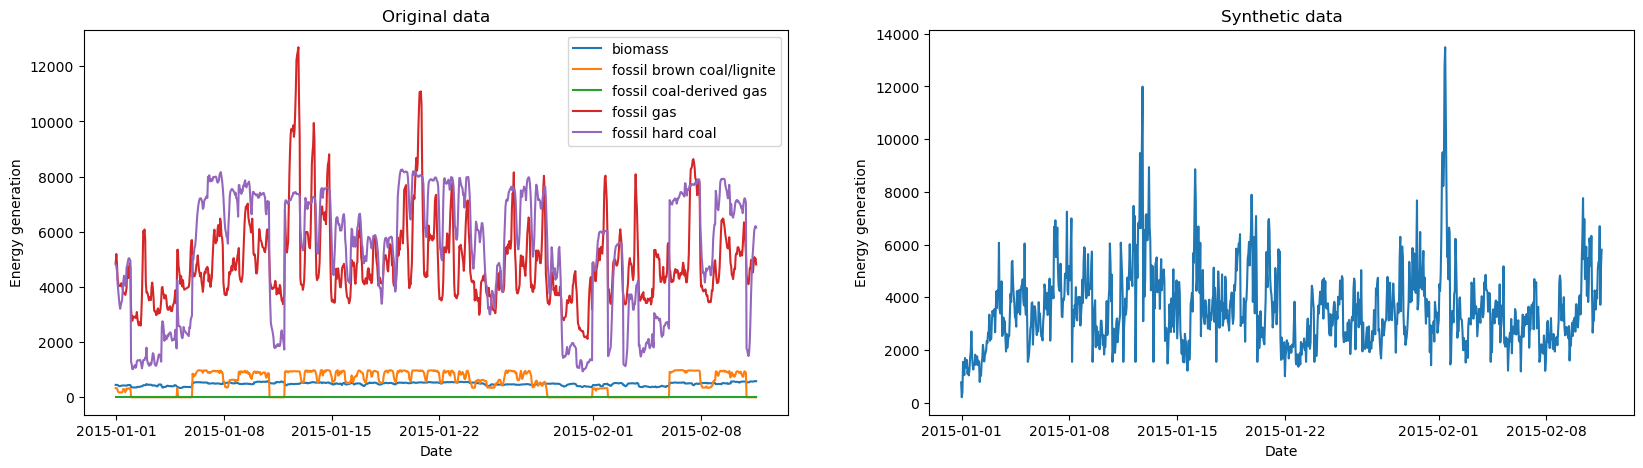

In [7]:
plot_original_synthetic_ts(df_long, synth_data, 5, 1)

# Compute DTW between synthetic and original

In [42]:
df_long, metadata = get_energy_data_metadata()

/opt/anaconda3/envs/CRP3/lib/python3.10/site-packages/sdv/datasets/local.py:31: UserWarning: Ignoring incompatible files ['.DS_Store'] in folder './data/'.
  warnings.warn(
2023-05-23 16:18:03,942 : MainThread : INFO : Detected metadata:
2023-05-23 16:18:03,942 : MainThread : INFO : {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "time": {
            "sdtype": "datetime"
        },
        "energy_source": {
            "sdtype": "categorical"
        },
        "value": {
            "sdtype": "numerical"
        }
    }
}


In [43]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 300, cuda = True)

# Step 2: Train the synthesizer
synthesizer.fit(df_long)

2023-05-23 16:18:14,792 : MainThread : INFO : Fitting table None metadata
2023-05-23 16:18:14,794 : MainThread : INFO : Fitting formatters for table None
2023-05-23 16:18:14,795 : MainThread : INFO : Fitting constraints for table None
2023-05-23 16:18:14,795 : MainThread : INFO : Setting the configuration for the ``HyperTransformer`` for table None
2023-05-23 16:18:14,820 : MainThread : INFO : Fitting table None metadata
2023-05-23 16:18:14,821 : MainThread : INFO : Fitting formatters for table None
2023-05-23 16:18:14,822 : MainThread : INFO : Fitting constraints for table None
2023-05-23 16:18:14,822 : MainThread : INFO : Fitting HyperTransformer for table None
2023-05-23 16:18:14,832 : MainThread : INFO : Fitting table None metadata
2023-05-23 16:18:14,833 : MainThread : INFO : Fitting formatters for table None
2023-05-23 16:18:14,833 : MainThread : INFO : Fitting constraints for table None
2023-05-23 16:18:14,834 : MainThread : INFO : Setting the configuration for the ``HyperTransf

In [44]:
synthesizer.save("models/energy1000_300ep_lin_int.pkl")

In [45]:
# Load synthesizer that you want
synthesizer = PARSynthesizer.load("models/energy1000_300ep_lin_int.pkl")

In [48]:
# Sample from it
synth_data = synthesizer.sample(20)

100%|██████████| 20/20 [02:06<00:00,  6.31s/it]


In [49]:
#synth_data.to_csv("synthetic_data/energy1000_20samples.csv")

In [50]:
dist_matrix = compute_dtw_matrix(df_long, synth_data, metadata)

In [87]:
dist_matrix

,biomass,fossil brown coal/lignite,fossil coal-derived gas,fossil gas,fossil hard coal,fossil oil,fossil oil shale,fossil peat,geothermal,hydro pumped storage consumption,hydro run-of-river and poundage,hydro water reservoir,marine,nuclear,other,other renewable,solar,waste,wind offshore,wind onshore
000bo,1015.241694,929.703467,1451.720317,710.682244,527.712181,1128.564760,1451.720317,1451.720317,1451.720317,553.039629,577.729644,468.597997,1451.720317,1173.231466,1381.535412,1381.470205,560.410141,1218.562998,1451.720317,1074.115545
000bp,709.894705,589.926613,909.259248,998.797770,748.352334,765.090193,909.259248,909.259248,909.259248,496.243533,505.665076,486.566543,909.259248,1544.355039,876.307666,884.591785,490.881418,808.928464,909.259248,1309.116763
000bq,1027.258868,889.946997,1211.767677,1059.665717,658.640176,1070.143339,1211.767677,1211.767677,1211.767677,589.314799,688.035844,506.366888,1211.767677,1365.271697,1176.875837,1179.472998,595.387916,1116.546074,1211.767677,990.493881
000br,960.943965,867.502474,1260.364676,740.851736,629.000368,1065.897277,1260.364676,1260.364676,1260.364676,561.446314,617.436705,479.231021,1260.364676,1245.994838,1198.896488,1190.217176,571.706816,1103.049689,1260.364676,987.016293
000bs,1069.944284,979.034627,1492.498528,721.509927,743.917033,1176.155672,1492.498528,1492.498528,1492.498528,532.095813,638.901841,447.363304,1492.498528,1142.753063,1422.064133,1423.375573,536.458978,1259.009401,1492.498528,1246.610071
000bt,1162.336648,1073.605083,1606.083314,674.652582,572.840871,1271.548788,1606.083314,1606.083314,1606.083314,670.725762,772.674955,469.326913,1606.083314,917.211116,1533.547422,1537.423054,610.875413,1369.801589,1606.083314,932.960408
000bu,968.039493,907.264277,1211.616593,744.616272,668.097725,1073.171192,1211.616593,1211.616593,1211.616593,570.559678,616.892180,461.537854,1211.616593,1006.885565,1184.803150,1184.309674,556.824164,1103.959422,1211.616593,1261.521428
000bv,968.198771,876.047143,1472.822142,800.678419,514.198472,1110.835139,1472.822142,1472.822142,1472.822142,594.086340,573.736195,439.936056,1472.822142,1183.128827,1391.154099,1402.203900,573.674264,1224.783318,1472.822142,1057.766655
000bw,1100.273660,1004.353156,1469.121946,724.927898,554.339621,1202.400422,1469.121946,1469.121946,1469.121946,643.168552,709.774385,468.343172,1469.121946,1125.678230,1400.693484,1399.750317,602.590541,1266.903053,1469.121946,1078.483555
000bx,881.549843,767.892002,1149.501287,821.667917,608.965870,959.391070,1149.501287,1149.501287,1149.501287,493.119220,516.084074,448.384494,1149.501287,1337.774949,1114.202972,1119.855988,557.142436,1021.721035,1149.501287,1089.847943


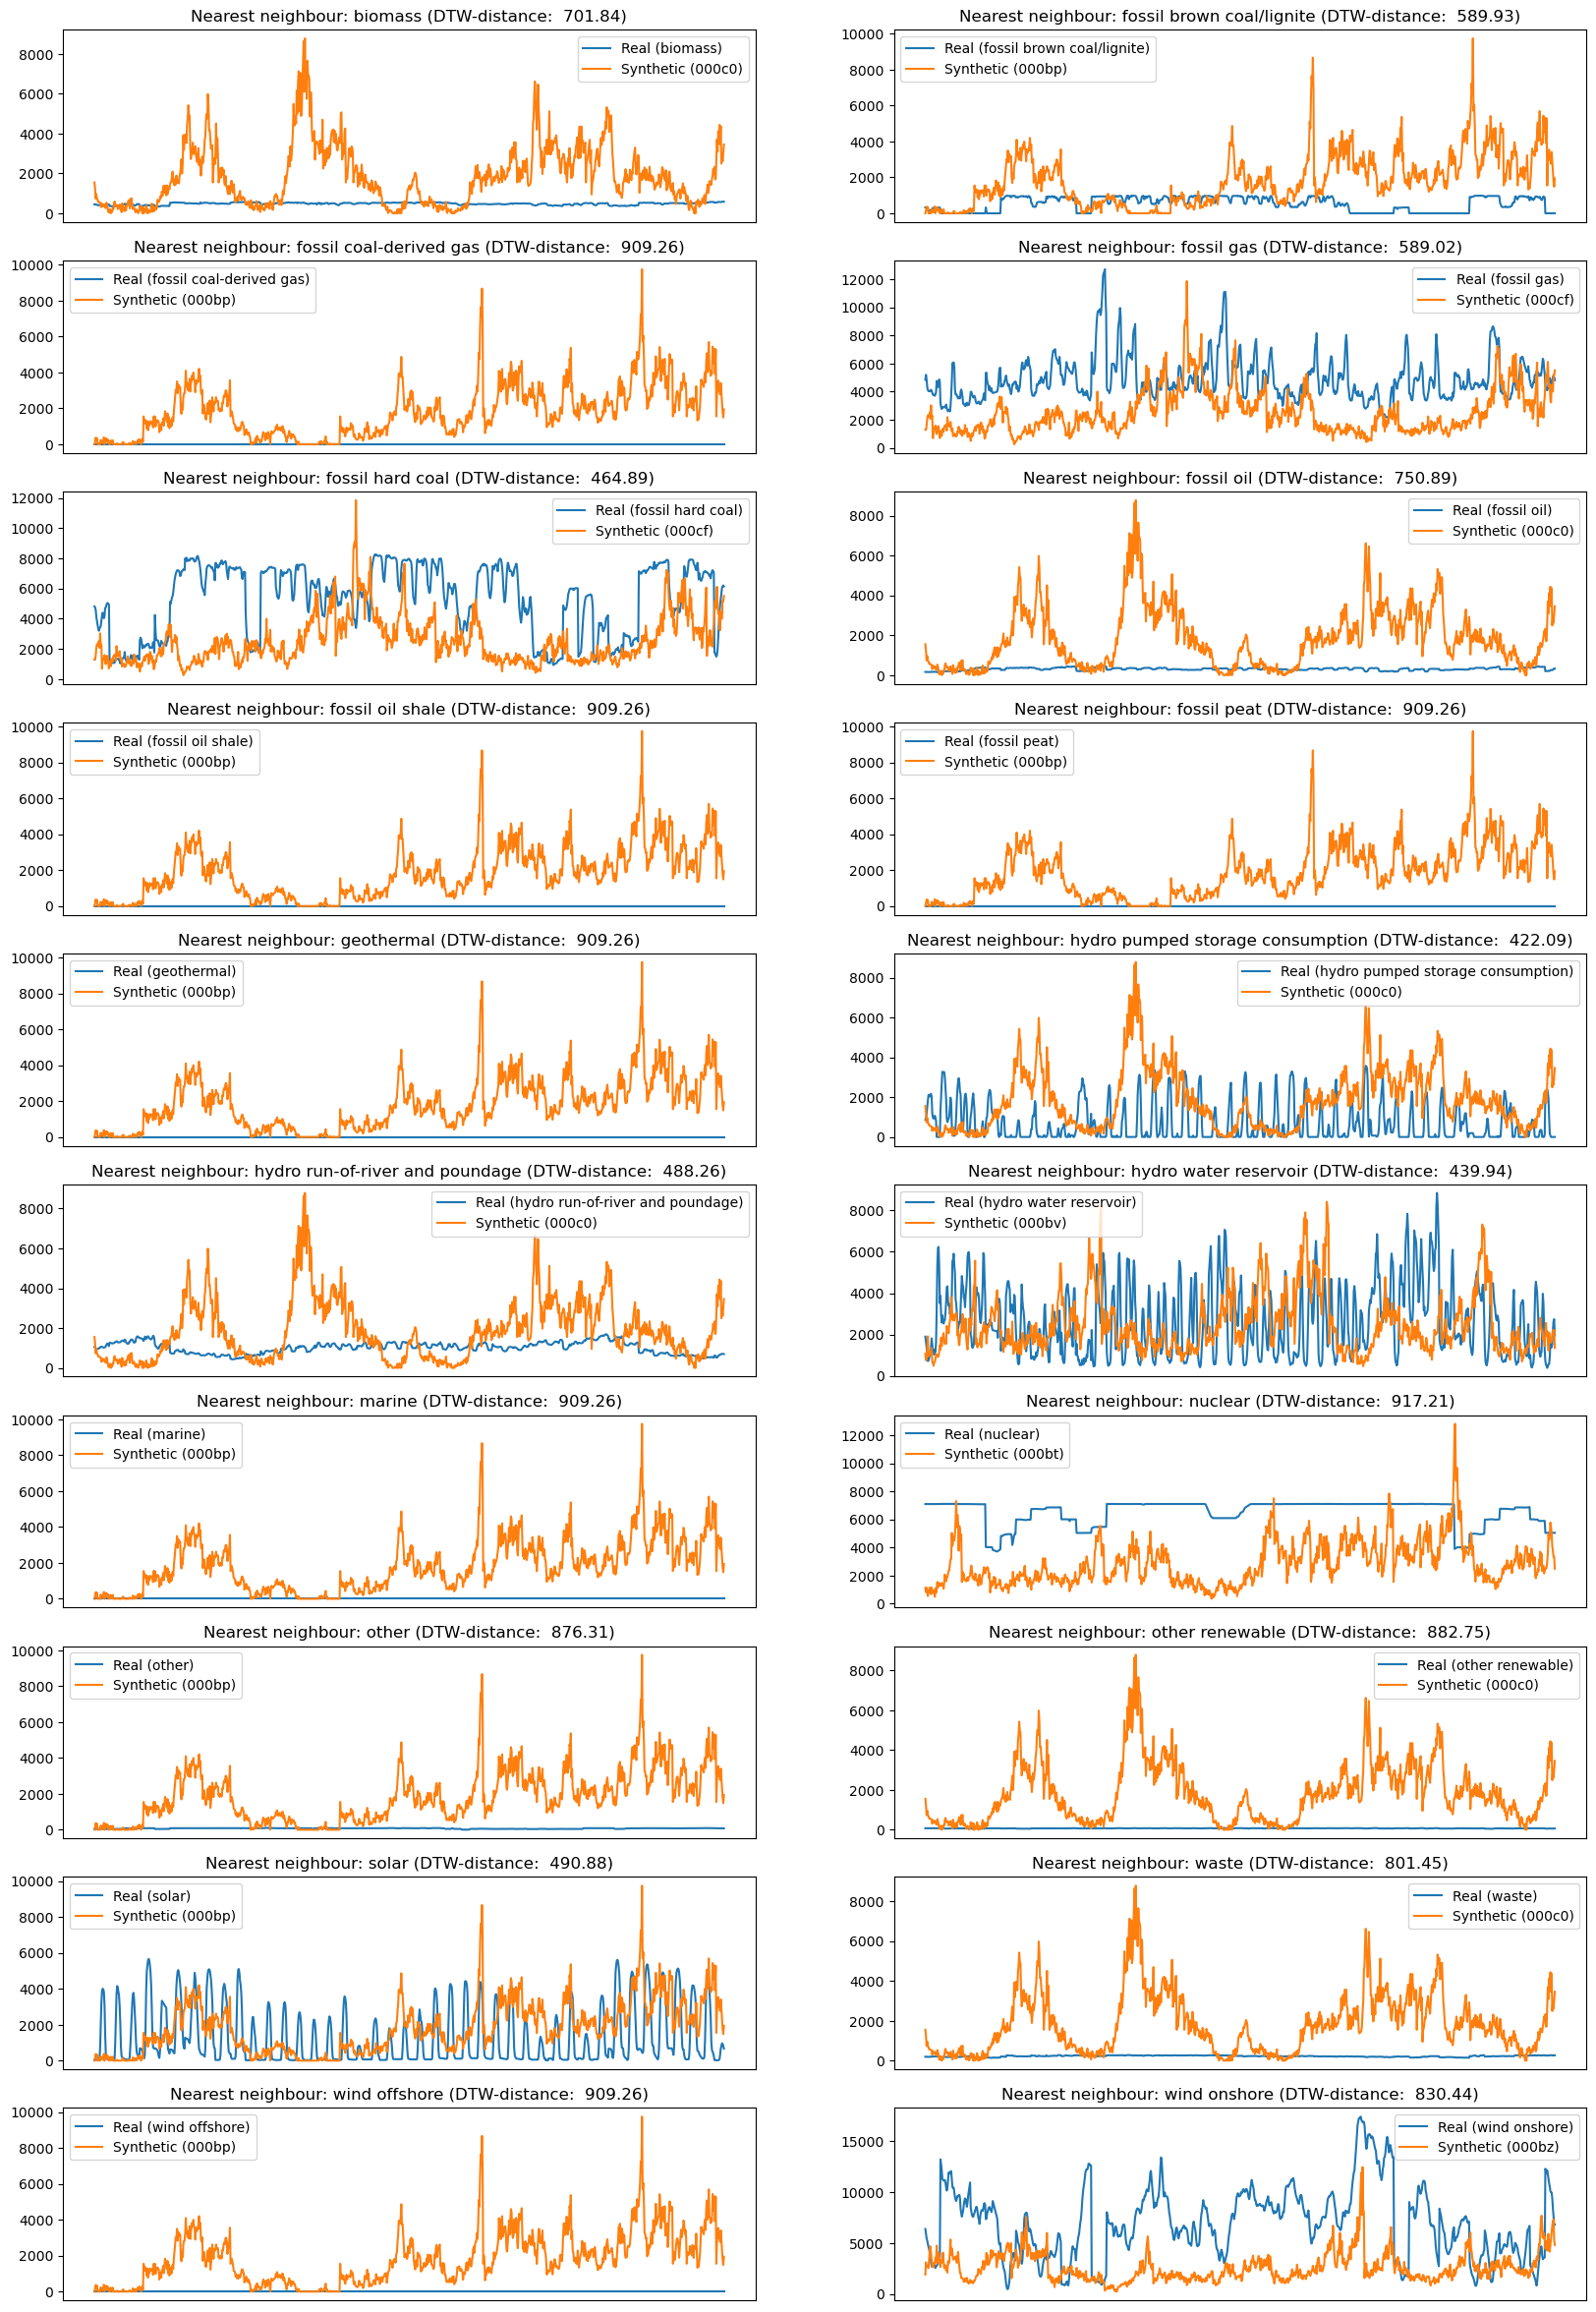

In [101]:
# Find the nearest neighbour's names
nearest_synth_ts = dist_matrix.idxmin(axis=0)

# Init plotting
n_plots = len(df_long["energy_source"].unique())
fig, axs = plt.subplots(nrows=n_plots//2, ncols=2, figsize=(20,30)) # TODO: account for odd number of plots by setting the last plot to ax.axis("off")
axs = axs.reshape(-1)

for i, (real_col, synth_name) in enumerate(nearest_synth_ts.items()):
    # Subset real dataset and extract y, x for plotting
    real_df_subset = df_long[df_long["energy_source"] == real_col]
    y_real = real_df_subset["value"]
    x_real = real_df_subset["time"]

    # Subset synthetic dataset and extract y, x for plotting
    synth_df_subset = synth_data[synth_data["energy_source"] == synth_name]
    y_synth = synth_df_subset["value"]
    x_synth = synth_df_subset["time"]

    axs[i].plot(x_real, y_real, label = f"Real ({real_col})")
    axs[i].plot(x_synth, y_synth, label = f"Synthetic ({synth_name})")
    axs[i].tick_params(axis='x', which='both', bottom=False,top=False,labelbottom=False)
    axs[i].set_title(f"Nearest neighbour: {real_col} (DTW-distance: {dist_matrix[real_col][synth_name]: .2f})")
    axs[i].legend()